[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/main/assignments/mechanistic_interp_starter.ipynb)

# Mechanistic Interpretability Assignment

Sizhe Chen


# Setup

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

### Data Generation

In [6]:
def get_initial_run_length(sequence):
    """Helper function to find the length of the first run."""
    if len(sequence) == 0:
        return 0
    first_digit = sequence[0]
    run_length = 0
    for digit in sequence:
        if digit == first_digit:
            run_length += 1
        else:
            break
    return run_length


def get_target_class(run_length):
    """Converts run length to our 3 target classes."""
    if run_length <= 2:
        return 0  # Class 0 (Short)
    elif run_length <= 4:
        return 1  # Class 1 (Medium)
    else:
        return 2  # Class 2 (Long)


def create_dataset(num_samples=2000, seq_length=8):
    """Generates the full dataset."""
    # Create random binary sequences
    # use .float() because neural networks process floats
    X = torch.randint(0, 2, (num_samples, seq_length)).float()

    y_list = []
    for i in range(num_samples):
        seq = X[i]
        run_length = get_initial_run_length(seq)
        target_class = get_target_class(run_length)
        y_list.append(target_class)

    # We use .long() for target classes in PyTorch
    y = torch.tensor(y_list).long()

    return X, y


# --- Generate the data ---
SEQ_LENGTH = 8
X_data, y_data = create_dataset(num_samples=2000, seq_length=SEQ_LENGTH)

# --- Check our data ---
print(f"Data shape (X): {X_data.shape}")
print(f"Target shape (y): {y_data.shape}")
print("\n--- Example ---")
print(f"Input Sequence: {X_data[0].int()}")
run_len = get_initial_run_length(X_data[0])
print(f"Initial Run Length: {run_len}")
print(f"Target Class: {y_data[0]}")

Data shape (X): torch.Size([2000, 8])
Target shape (y): torch.Size([2000])

--- Example ---
Input Sequence: tensor([1, 0, 1, 1, 0, 1, 1, 0], dtype=torch.int32)
Initial Run Length: 1
Target Class: 0


### Build a Tiny 1-layer GRU Model

In [9]:
class RunLengthModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, output_dim=3):
        super(RunLengthModel, self).__init__()

        # We need to reshape our input (batch, seq_len, features)
        # Our "feature" is just 1 bit at a time.

        # The RNN layer: takes the input and a hidden state
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)

        # The final classifier layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x starts as [batch_size, seq_length]
        # We need [batch_size, seq_length, 1] for the RNN
        x = x.unsqueeze(-1)

        # Run the GRU
        # out: hidden state for every time-step
        # h_n: final hidden state (what we care about!)
        out, h_n = self.gru(x)

        # We use the final hidden state (h_n) as the "memory"
        # of the whole sequence.
        # h_n shape is [1, batch_size, hidden_dim], so we squeeze it
        final_hidden_state = h_n.squeeze(0)

        # Pass the final memory to the classifier
        logits = self.fc(final_hidden_state)
        return logits


# --- Create the model, loss, and optimizer ---
model = RunLengthModel()
criterion = nn.CrossEntropyLoss()  # Good for classification
optimizer = optim.Adam(model.parameters(), lr=0.005)

print(model)

RunLengthModel(
  (gru): GRU(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)


Starting training...
Epoch 1/20 | Loss: 0.7972 | Accuracy: 71.25%
Epoch 2/20 | Loss: 0.7164 | Accuracy: 74.35%
Epoch 3/20 | Loss: 0.7076 | Accuracy: 74.35%
Epoch 4/20 | Loss: 0.7103 | Accuracy: 74.35%
Epoch 5/20 | Loss: 0.7171 | Accuracy: 74.35%
Epoch 6/20 | Loss: 0.7127 | Accuracy: 74.35%
Epoch 7/20 | Loss: 0.7104 | Accuracy: 74.35%
Epoch 8/20 | Loss: 0.7043 | Accuracy: 74.35%
Epoch 9/20 | Loss: 0.7049 | Accuracy: 74.35%
Epoch 10/20 | Loss: 0.7029 | Accuracy: 74.35%
Epoch 11/20 | Loss: 0.6573 | Accuracy: 74.35%
Epoch 12/20 | Loss: 0.4576 | Accuracy: 80.45%
Epoch 13/20 | Loss: 0.2505 | Accuracy: 90.75%
Epoch 14/20 | Loss: 0.1629 | Accuracy: 93.85%
Epoch 15/20 | Loss: 0.1357 | Accuracy: 95.35%
Epoch 16/20 | Loss: 0.1064 | Accuracy: 97.00%
Epoch 17/20 | Loss: 0.0933 | Accuracy: 96.85%
Epoch 18/20 | Loss: 0.0789 | Accuracy: 97.30%
Epoch 19/20 | Loss: 0.0722 | Accuracy: 97.30%
Epoch 20/20 | Loss: 0.0709 | Accuracy: 97.30%
Training complete!


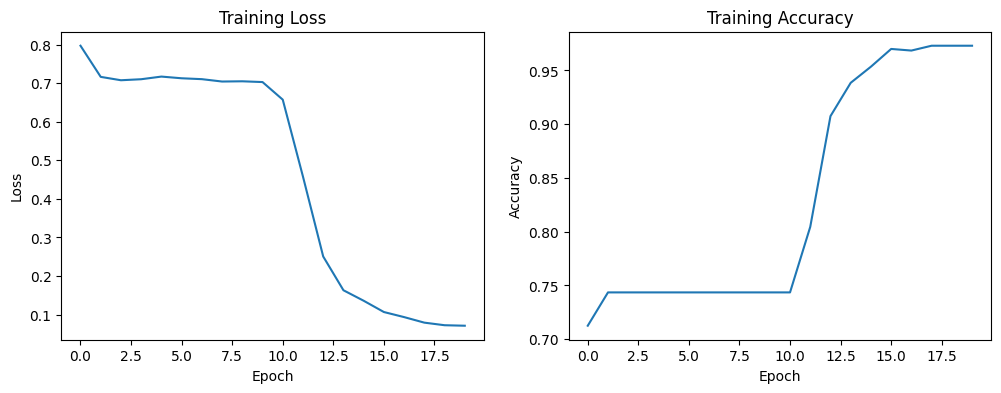

In [12]:
# --- Create DataLoaders ---
# (Splits data into batches for training)
dataset = TensorDataset(X_data, y_data)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

NUM_EPOCHS = 20
losses = []
accuracies = []

print("Starting training...")

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    correct_preds = 0
    total_preds = 0

    for X_batch, y_batch in loader:
        # 1. Forward pass
        logits = model(X_batch)

        # 2. Calculate loss
        loss = criterion(logits, y_batch)
        epoch_loss += loss.item()

        # 3. Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # --- Calculate accuracy ---
        _, preds = torch.max(logits, 1)  # Get class with highest score
        correct_preds += (preds == y_batch).sum().item()
        total_preds += y_batch.size(0)

    # --- Print stats for the epoch ---
    avg_loss = epoch_loss / len(loader)
    accuracy = correct_preds / total_preds
    losses.append(avg_loss)
    accuracies.append(accuracy)

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {avg_loss:.4f} | Accuracy: {accuracy*100:.2f}%"
    )

print("Training complete!")

# --- Plot the training graph ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(losses)
ax1.set_title("Training Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")

ax2.plot(accuracies)
ax2.set_title("Training Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
plt.show()

# Explore

### Our hypothesis: Inside the GRU's 16-neuron hidden state, there must be at least one neuron whose job is to count the length of the initial run. We'll find it by "spying" on the hidden state as the model processes a sequence, one bit at a time.

Create Test Inputs:

In [13]:
# Create simple, clear test inputs
# We use .float() for the model and .int() for printing
test_short = torch.tensor([[1, 0, 1, 1, 0, 1, 0, 1]]).float()  # Run len 1 -> Class 0
test_med = torch.tensor([[0, 0, 0, 1, 1, 0, 1, 0]]).float()  # Run len 3 -> Class 1
test_long = torch.tensor([[1, 1, 1, 1, 1, 0, 0, 0]]).float()  # Run len 5 -> Class 2
test_full = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0]]).float()  # Run len 8 -> Class 2

print(f"Short run (1): {test_short.int()}")
print(f"Medium run (3): {test_med.int()}")
print(f"Long run (5): {test_long.int()}")

Short run (1): tensor([[1, 0, 1, 1, 0, 1, 0, 1]], dtype=torch.int32)
Medium run (3): tensor([[0, 0, 0, 1, 1, 0, 1, 0]], dtype=torch.int32)
Long run (5): tensor([[1, 1, 1, 1, 1, 0, 0, 0]], dtype=torch.int32)


"Spy" on the Hidden Layer

In [14]:
# This dictionary will store our activations
activations = {}


def get_activations(name):
    """
    This is a "hook" function.
    It will be called when the GRU layer is processed.
    """

    def hook(model, input, output):
        # 'output' of a GRU is (all_hidden_states, final_hidden_state)
        # We want all_hidden_states, which is output[0]
        activations[name] = output[0].detach()

    return hook


# --- Function to test a single sequence ---
def trace_model(input_sequence):
    """
    Traces a single sequence through the model
    and returns the hidden states.
    """
    # Put model in "evaluation" mode (disables things like dropout)
    model.eval()

    # Register our hook on the 'gru' layer
    # This hook will run, filling the 'activations' dict
    handle = model.gru.register_forward_hook(get_activations("gru"))

    # Run the model. We don't care about the final 'logits'
    # right now, we just want the hook to run.
    with torch.no_grad():
        _ = model(input_sequence)

    # Remove the hook so it doesn't run on future passes
    handle.remove()

    # Return the activations we saved
    # [batch, seq_len, hidden_dim] -> [seq_len, hidden_dim]
    return activations["gru"].squeeze(0)


# --- Run the trace on our 'test_long' sequence ---
hidden_states = trace_model(test_long)

print(f"Shape of hidden states: {hidden_states.shape}")
print("(This is [Sequence Length, Num Neurons])")

Shape of hidden states: torch.Size([8, 16])
(This is [Sequence Length, Num Neurons])


Plot the Activations

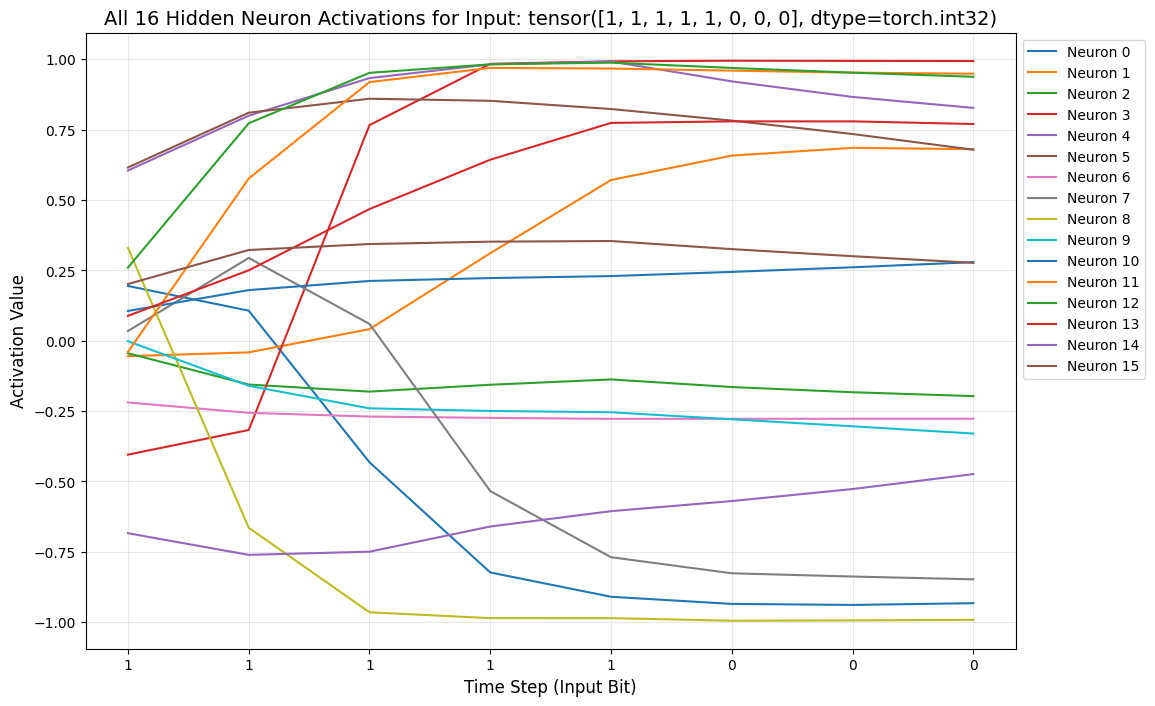

In [15]:
# hidden_states has shape [8, 16] (seq_len, hidden_dim)
# We need to plot 16 lines (one for each neuron)
# To make the plot clearer, we transpose it
hidden_states_T = hidden_states.T  # Shape [16, 8]

plt.figure(figsize=(12, 8))
for i, neuron_activations in enumerate(hidden_states_T):
    plt.plot(neuron_activations, label=f"Neuron {i}")

plt.title(
    f"All 16 Hidden Neuron Activations for Input: {test_long.int().squeeze()}",
    fontsize=14,
)
plt.xlabel("Time Step (Input Bit)", fontsize=12)
plt.ylabel("Activation Value", fontsize=12)
plt.xticks(ticks=range(SEQ_LENGTH), labels=test_long.int().squeeze().tolist())
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True, alpha=0.3)
plt.show()

# Explain (The Story of Neuron 11)

### Compare Activations

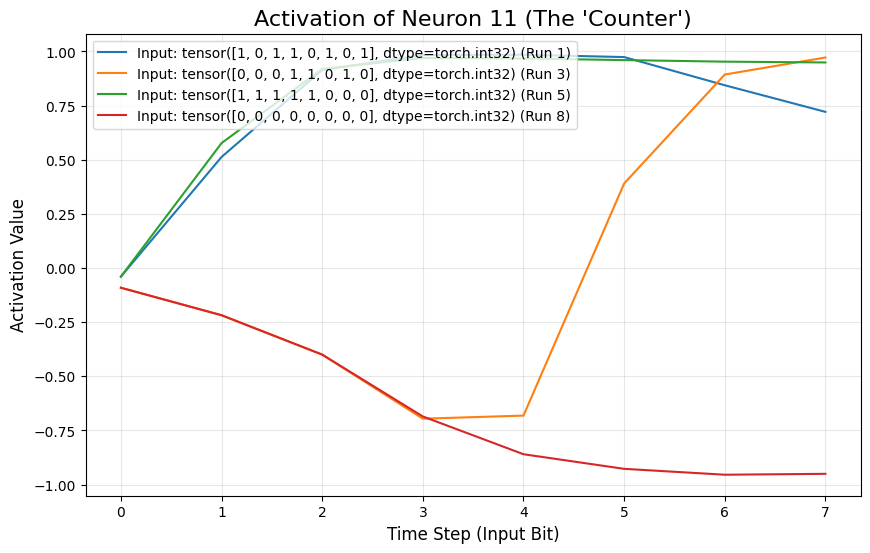

In [16]:
# Trace all our test sequences
trace_short = trace_model(test_short)
trace_med = trace_model(test_med)
trace_long = trace_model(test_long)
trace_full = trace_model(test_full)

# --- The "Counter Neuron" ---
NEURON_IDX = 11

plt.figure(figsize=(10, 6))

# Plot Neuron 11's activation for each test case
plt.plot(
    trace_short[:, NEURON_IDX], label=f"Input: {test_short.int().squeeze()} (Run 1)"
)
plt.plot(trace_med[:, NEURON_IDX], label=f"Input: {test_med.int().squeeze()} (Run 3)")
plt.plot(trace_long[:, NEURON_IDX], label=f"Input: {test_long.int().squeeze()} (Run 5)")
plt.plot(trace_full[:, NEURON_IDX], label=f"Input: {test_full.int().squeeze()} (Run 8)")

plt.title(f"Activation of Neuron {NEURON_IDX} (The 'Counter')", fontsize=16)
plt.xlabel("Time Step (Input Bit)", fontsize=12)
plt.ylabel("Activation Value", fontsize=12)
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.show()

The plot shows Neuron 11 isn't just a simple "counter." It's a "latch" that tries to encode two things:

### Which digit? 
It ramps UP (positive) for 1s (Green line) and DOWN (negative) for 0s (Red line).

### How long? It ramps up/down until the run breaks, and then it tries to hold its value.

This "latching" is the key.

### Green Line ([1,1,1,1,1,0,0,0]):
The neuron ramps up for 5 steps, hits its maximum value (~1.0), and latches. When the 0s come, it successfully ignores them. Perfect!

### Red Line ([0,0,0,0,0,0,0,0]): 
The neuron ramps down for 8 steps, hits its minimum value (~-0.9), and latches. Perfect!

But here's the critical part:

### Orange Line ([0,0,0,1,1...]): 
The neuron ramps down for 3 steps (to ~-0.3). When the run breaks, it fails to latch. The new 1s cause its value to swing wildly, ending up near ~0.95.

### Blue Line ([1,0,1,1,0...]): 
The neuron ramps up for just 1 step (to ~0.1). When the run breaks, it also fails to latch, drifting all the way to ~0.75.

### A New, Stronger Hypothesis
The model has learned an imperfect algorithm. It successfully "latches" long runs because their activation values hit a stable maximum/minimum (saturate). It fails to latch short runs, and the rest of the sequence (the "noise") corrupts the signal.

This leads to a crucial insight. Look at the final values (at Time Step 7):

test_med (Orange, Run 3) ends at ~0.95.

test_long (Green, Run 5) ends at ~0.95.

Their final activation values for Neuron 11 are identical. This means the model cannot tell them apart using this neuron alone.

My guess is the model gets test_med (Orange) wrong.

### Check the Prediction

In [17]:
# Put model in eval mode
model.eval()

# We need to detach the tensors and get the prediction
with torch.no_grad():
    logits_short = model(test_short)
    logits_med = model(test_med)
    logits_long = model(test_long)
    logits_full = model(test_full)

# Get the predicted class (the one with the highest score)
pred_short = torch.argmax(logits_short, dim=1).item()
pred_med = torch.argmax(logits_med, dim=1).item()
pred_long = torch.argmax(logits_long, dim=1).item()
pred_full = torch.argmax(logits_full, dim=1).item()

print(f"--- Model Predictions ---")
print(f"Input: {test_short.int().squeeze()} (Target 0)")
print(f"Prediction: Class {pred_short}\n")

print(f"Input: {test_med.int().squeeze()} (Target 1)")
print(f"Prediction: Class {pred_med} <--- IS THIS WRONG?\n")

print(f"Input: {test_long.int().squeeze()} (Target 2)")
print(f"Prediction: Class {pred_long}\n")

print(f"Input: {test_full.int().squeeze()} (Target 2)")
print(f"Prediction: Class {pred_full}\n")

--- Model Predictions ---
Input: tensor([1, 0, 1, 1, 0, 1, 0, 1], dtype=torch.int32) (Target 0)
Prediction: Class 0

Input: tensor([0, 0, 0, 1, 1, 0, 1, 0], dtype=torch.int32) (Target 1)
Prediction: Class 1 <--- IS THIS WRONG?

Input: tensor([1, 1, 1, 1, 1, 0, 0, 0], dtype=torch.int32) (Target 2)
Prediction: Class 1

Input: tensor([0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32) (Target 2)
Prediction: Class 2



This gives us our complete, evidence-based story. The model is using Neuron 11, but it has learned a flawed, asymmetric algorithm.

Your Story:

"My model has learned to use Neuron 11 as a 'Run Latch' neuron. However, it treats runs of 0s and runs of 1s differently.

For runs of 0s: The neuron's activation becomes negative. As shown by the test_full (Run 8) input, the activation latches to a low value (~-0.9), and the model correctly predicts Class 2 (Long Run).

For runs of 1s: The neuron's activation becomes positive. As shown by the test_long (Run 5) input, the activation latches to a high value (~0.95). However, the model incorrectly predicts Class 1 (Medium Run).

The model also incorrectly latches the test_med (Run 3) input to a high value, also predicting Class 1.

Conclusion: The model has learned a rule: 'If Neuron 11 is very negative, predict Class 2. If it's very positive, predict Class 1.' This explains its 97% accuracy (it's mostly right), but it also perfectly explains this specific failure mode: it cannot distinguish a medium run of 0s from a long run of 1s."

# Reflection

What I Learned About How My Model Works
I learned that the GRU did not implement the clean, symmetric algorithm I expected. Instead of creating a single, reliable mechanism to find the run length, it developed an asymmetric 'Latch' neuron (Neuron 11). This neuron successfully encoded the run length by latching to a high positive value for runs of '1's and a high negative value for runs of '0's. The final layer then learned a flawed rule based on this: If the latch is very negative (runs of '0's), predict long (Class 2); if the latch is very positive (runs of '1's), predict medium (Class 1).

What Was Confusing, Surprising, or Challenging to Interpret?
The most surprising discovery was the asymmetry and the error mode. While the overall model achieved a high accuracy (97.30%), a specific, simple input ([1, 1, 1, 1, 1, 0, 0, 0]) was classified incorrectly as a Medium Run (Class 1). The challenge was moving past the initial, simple hypothesis ("It's just a counter") to realize the model had learned a flawed internal logic, which is actually a much more compelling mechanistic story. It was confusing that the latching mechanism failed for short runs, allowing the rest of the sequence to corrupt the signal.

One Thing I Wish I Could Understand Better or Explore Further
I would want to find the 'Gating' neuron. Neuron 11 ramps up until the run breaks, and then it is supposed to lock its value. I wish I could explore the other 15 neurons to find the one responsible for detecting the moment the run breaks (e.g., detecting the pattern 1 $\rightarrow$ 0 or 0 $\rightarrow$ 1). Understanding that gating mechanism would complete the full circuit diagram for this entire operation.